# Global Mean Response: scatter
* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

## import and params

In [66]:
%matplotlib notebook
!date

import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['hatch.color']='g'
import xarray as xr
from scipy.stats import ttest_1samp
import statsmodels.api as sm

from plotsetting import *
from geoplots import mapplot, xticksyear, xticksmonth
import geoxarray, xlearn

Wed Jul 18 16:51:18 EDT 2018


In [55]:
# parameters
data_names = ['netrad_toa', 't_surf', 'sfc_hflux_coupler', 'swdn_sfc_clr', 'swup_toa_clr'][0:3]
figname = f'figs/fig_globalMean.scatter.pdf'
prcp_scale = 3600 * 24

nino_ens = [1, 3, 4, 7, 9, 12, 17, 22, 26, 29]
nina_ens = [2, 5, 6, 8, 10, 11, 16, 23, 27, 30]
neut_ens = [13, 14, 15, 18, 19, 20, 21, 24, 25, 28]

ds = xr.open_dataset('/tigress/wenchang/MODEL_OUT/CTL1860_noleap_tigercpu_intelmpi_18_576PE/POSTP/00010101.ocean_grid.nc')
ocean_tgrid_area = ds.area_t + ds.ht*0 # ds.ht*0 is the land mask in ocean grids

# land/ocean grids
new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}
ds = xr.open_dataset('/tigress/wenchang/MODEL_OUT/CTL1860_noleap_tigercpu_intelmpi_18_576PE/POSTP/00010101.atmos_month.nc')
land_mask = ds.land_mask.rename(new_names)
# land_area = ds.area + land_mask.where(land_mask>.5) * 0 #
# ocean_area = ds.area + land_mask.where(land_mask<.5) * 0 # land mask in atmos grids
# land_area = land_area.rename(new_names)
# ocean_area = ocean_area.rename(new_names)
# global_area = ds.area.rename(new_names)
land_grids = land_mask.where(land_mask>.5) * 0 #
ocean_grids = land_mask.where(land_mask<.5) * 0 # land mask in atmos grids

# global mean for ocean data
def area_mean(da, yt_ocean=None):
    '''area-weighted average for ocean data'''
    if yt_ocean is None:
        da_ = da
        area = ocean_tgrid_area
    else:
        da_ = da.sel(yt_ocean=yt_ocean)
        area = ocean_tgrid_area.sel(yt_ocean=yt_ocean)
    return (da * area).sum(['xt_ocean', 'yt_ocean'])/area.sum()

# The following codes do not work since the variable "area" is not the actual area in the lon/lat grids
# # land/ocean mean for atmos data
# def atmos_area_mean(da, grids):
#     '''area-weighted average over land/ocean for atmos data'''
#     if grids in ('land',):
#         area = land_area
#     elif grids in ('ocean',):
#         area = ocean_area
#     else:
#         area = global_area
#     return (da * area).sum(['lat', 'lon'])/area.sum()

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


## Data

### Agung data

In [54]:
# Agung data
tsas_agung = dict()
for data_name in data_names:
    from data_CTL1860 import open_ensemble as get_ctl
    from data_agung import open_data as get_volcano
    volcano_name = 'Agung'
    year_volcano = 1963
    ens = range(1,31)
    nbname = 'volcano_impact_on_climate_agung.ipynb'
    new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}

    ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
    try:
        da_ctl = xr.open_dataarray(ncfile).load()
        print('Data loaded from', ncfile)
    except:
        da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
        da_ctl.to_dataset().to_netcdf(ncfile)
        print('Data calculated and saved to', ncfile)

    ncfile = f'cache/{nbname}.{data_name}.nc'
    try:
        da_volcano = xr.open_dataarray(ncfile).load()
        print('Data loaded from', ncfile)
    except:
        da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
        da_volcano.to_dataset().to_netcdf(ncfile)
        print('Data calculated and saved to', ncfile)

    daa = da_volcano - da_ctl
    if data_name in ('precip',):
        daa = daa * prcp_scale
        
    tsas_agung[data_name] = dict()
    if data_name in ('sfc_hflux_coupler',): # area mean for ocean grids
        tsas_agung[data_name]['Global'] = area_mean(daa)
        tsas_agung[data_name]['NH'] = area_mean(daa, yt_ocean=slice(0,90))
        tsas_agung[data_name]['SH'] = area_mean(daa, yt_ocean=slice(-90,0))
    else:
        tsas_agung[data_name]['Global'] = daa.geo.fldmean()
        tsas_agung[data_name]['NH'] = daa.sel(lat=slice(0,90)).geo.fldmean()
        tsas_agung[data_name]['SH'] = daa.sel(lat=slice(-90,0)).geo.fldmean()
        tsas_agung[data_name]['land'] = (daa + land_grids).geo.fldmean()
        tsas_agung[data_name]['ocean'] = (daa + ocean_grids).geo.fldmean()

Data loaded from cache/volcano_impact_on_climate_agung.ipynb.netrad_toa.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.netrad_toa.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.t_surf.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.t_surf.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.swdn_sfc_clr.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.swdn_sfc_clr.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.swup_toa_clr.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.swup_toa_clr.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.sfc_hflux_coupler.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.sfc_hflux_coupler.nc


### StMaria data

In [56]:
# St Maria data
tsas_stmaria = dict()
for data_name in data_names:
    from data_CTL1860 import open_ensemble as get_ctl
    from data_stmaria import open_data as get_volcano
    volcano_name = 'StMaria'
    year_volcano = 1902
    ens = range(1,30+1)
    nbname = 'volcano_impact_on_climate_stmaria.ipynb'
    new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}

    ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
    try:
        da_ctl = xr.open_dataarray(ncfile).load()
        print('Data loaded from', ncfile)
    except:
        da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
        da_ctl.to_dataset().to_netcdf(ncfile)
        print('Data calculated and saved to', ncfile)

    ncfile = f'cache/{nbname}.{data_name}.nc'
    try:
        da_volcano = xr.open_dataarray(ncfile).load()
        print('Data loaded from', ncfile)
    except:
        da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
        da_volcano.to_dataset().to_netcdf(ncfile)
        print('Data calculated and saved to', ncfile)

    daa = da_volcano - da_ctl
    if data_name in ('precip',):
        daa = daa * prcp_scale
    
    tsas_stmaria[data_name] = dict()
    if data_name in ('sfc_hflux_coupler',): # area mean for ocean grids
        tsas_stmaria[data_name]['Global'] = area_mean(daa)
        tsas_stmaria[data_name]['NH'] = area_mean(daa, yt_ocean=slice(0,90))
        tsas_stmaria[data_name]['SH'] = area_mean(daa, yt_ocean=slice(-90,0))
    else:
        tsas_stmaria[data_name]['Global'] = daa.geo.fldmean()
        tsas_stmaria[data_name]['NH'] = daa.sel(lat=slice(0,90)).geo.fldmean()
        tsas_stmaria[data_name]['SH'] = daa.sel(lat=slice(-90,0)).geo.fldmean()
        tsas_stmaria[data_name]['land'] = (daa + land_grids).geo.fldmean()
        tsas_stmaria[data_name]['ocean'] = (daa + ocean_grids).geo.fldmean()

Data loaded from cache/volcano_impact_on_climate_stmaria.ipynb.netrad_toa.ctl.nc
Data loaded from cache/volcano_impact_on_climate_stmaria.ipynb.netrad_toa.nc
Data loaded from cache/volcano_impact_on_climate_stmaria.ipynb.t_surf.ctl.nc
Data loaded from cache/volcano_impact_on_climate_stmaria.ipynb.t_surf.nc
Data loaded from cache/volcano_impact_on_climate_stmaria.ipynb.sfc_hflux_coupler.ctl.nc
Data loaded from cache/volcano_impact_on_climate_stmaria.ipynb.sfc_hflux_coupler.nc


### Pinatubo data

In [57]:
# Pinatubo data
tsas_pinatubo = dict()
for data_name in data_names:
    from data_CTL1860 import open_ensemble as get_ctl
    from data_pinatubo import open_data as get_volcano
    volcano_name = 'Pinatubo'
    year_volcano = 1991
    ens = range(1,30+1)
    nbname = 'volcano_impact_on_climate_pinatubo.ipynb'
    new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}

    ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
    try:
        da_ctl = xr.open_dataarray(ncfile).load()
        print('Data loaded from', ncfile)
    except:
        da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
        da_ctl.to_dataset().to_netcdf(ncfile)
        print('Data calculated and saved to', ncfile)

    ncfile = f'cache/{nbname}.{data_name}.nc'
    try:
        da_volcano = xr.open_dataarray(ncfile).load()
        print('Data loaded from', ncfile)
    except:
        da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
        da_volcano.to_dataset().to_netcdf(ncfile)
        print('Data calculated and saved to', ncfile)

    daa = da_volcano - da_ctl
    if data_name in ('precip',):
        daa = daa * prcp_scale
    
    tsas_pinatubo[data_name] = dict()
    if data_name in ('sfc_hflux_coupler',): # area mean for ocean grids
        tsas_pinatubo[data_name]['Global'] = area_mean(daa)
        tsas_pinatubo[data_name]['NH'] = area_mean(daa, yt_ocean=slice(0,90))
        tsas_pinatubo[data_name]['SH'] = area_mean(daa, yt_ocean=slice(-90,0))
    else:
        tsas_pinatubo[data_name]['Global'] = daa.geo.fldmean()
        tsas_pinatubo[data_name]['NH'] = daa.sel(lat=slice(0,90)).geo.fldmean()
        tsas_pinatubo[data_name]['SH'] = daa.sel(lat=slice(-90,0)).geo.fldmean()
        tsas_pinatubo[data_name]['land'] = (daa + land_grids).geo.fldmean()
        tsas_pinatubo[data_name]['ocean'] = (daa + ocean_grids).geo.fldmean()

Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.netrad_toa.ctl.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.netrad_toa.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.t_surf.ctl.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.t_surf.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.sfc_hflux_coupler.ctl.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.sfc_hflux_coupler.nc


## plot

<IPython.core.display.Javascript object>


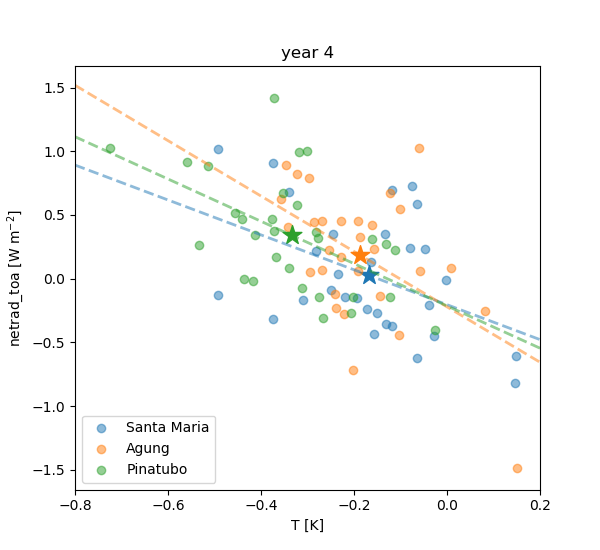

Santa Maria
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     7.055
Date:                Wed, 18 Jul 2018   Prob (F-statistic):             0.0129
Time:                        16:52:14   Log-Likelihood:                -16.306
No. Observations:                  30   AIC:                             36.61
Df Residuals:                      28   BIC:                             39.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2040      0.117     -1.

Text(0.5,1,'year 4')

In [68]:
# scatter plot: forcing netrad_toa of year 4, response of year 4
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -.8
Tmax = .2
iyear = 4


volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()


plt.legend(frameon=True, loc='lower left')
plt.ylabel(r'netrad_toa [W m$^{-2}$]')
plt.xlabel(r'T [K]')
plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)
plt.title(f'year {iyear}')

<IPython.core.display.Javascript object>


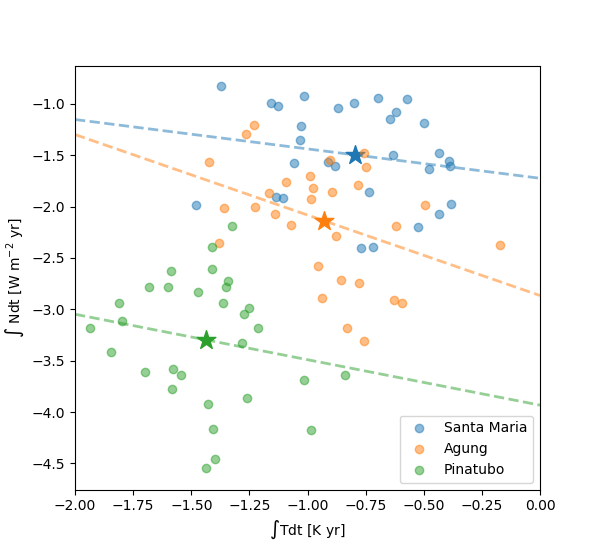

Santa Maria
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.022
Date:                Tue, 17 Jul 2018   Prob (F-statistic):              0.321
Time:                        16:22:42   Log-Likelihood:                -18.470
No. Observations:                  30   AIC:                             40.94
Df Residuals:                      28   BIC:                             43.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7244      0.241     -7.

(-2, 0)

In [189]:
# scatter plot: forcing netrad_toa over year 5, response over year 5
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -2
Tmax = 0


volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()


plt.legend(frameon=True)
plt.ylabel(r'$\int$ Ndt [W m$^{-2}$ yr]')
plt.xlabel(r'$\int $Tdt [K yr]')
plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)

## `netrad_toa` vs `t_surf` in each month

In [276]:
tsX.rolling(center=True, time=12).mean()

<xarray.DataArray (en: 30, time: 60)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-02-01 1991-03-01 ...
  * en       (en) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [283]:
# beta as the function of year
beta = dict()
p = dict()
volc = 'stmaria'
year = 1902
tsX = tsas_stmaria['t_surf']['Global'].rolling(center=True, time=12).mean()
tsY = tsas_stmaria['netrad_toa']['Global'].rolling(center=True, time=12).mean()
time_values = tsX.time.values
beta[volc] = np.zeros(time_values.shape)
p[volc] = np.zeros(time_values.shape)
for i,t in enumerate(time_values):
    dT = tsX.sel(time=t)
    dR = tsY.sel(time=t)
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][i] = -result.params[1]
    p[volc][i] = result.pvalues[1]

volc = 'agung'
year = 1963
tsX = tsas_agung['t_surf']['Global'].rolling(center=True, time=12).mean()
tsY = tsas_agung['netrad_toa']['Global'].rolling(center=True, time=12).mean()
time_values = tsX.time.values
beta[volc] = np.zeros(time_values.shape)
p[volc] = np.zeros(time_values.shape)
for i,t in enumerate(time_values):
    dT = tsX.sel(time=t)
    dR = tsY.sel(time=t)
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][i] = -result.params[1]
    p[volc][i] = result.pvalues[1]


volc = 'pinatubo'
year = 1991
tsX = tsas_pinatubo['t_surf']['Global'].rolling(center=True, time=12).mean()
tsY = tsas_pinatubo['netrad_toa']['Global'].rolling(center=True, time=12).mean()
time_values = tsX.time.values
beta[volc] = np.zeros(time_values.shape)
p[volc] = np.zeros(time_values.shape)
for i,t in enumerate(time_values):
    dT = tsX.sel(time=t)
    dR = tsY.sel(time=t)
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][i] = -result.params[1]
    p[volc][i] = result.pvalues[1]

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


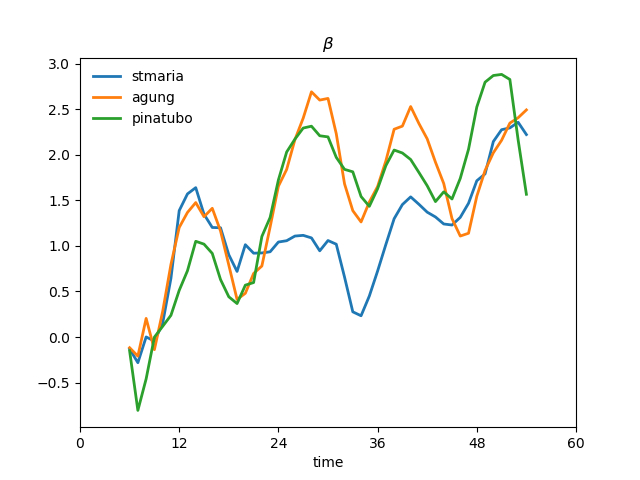

([<matplotlib.axis.XTick at 0x2b787a4ea1d0>,
 <a list of 6 Text xticklabel objects>)

In [289]:
for volc in ['stmaria', 'agung', 'pinatubo']:
    plot(beta[volc], label=volc)
plt.legend()
plt.title(r'$\beta$')
plt.xlabel('time')
plt.xticks(range(0,61,12))

<IPython.core.display.Javascript object>


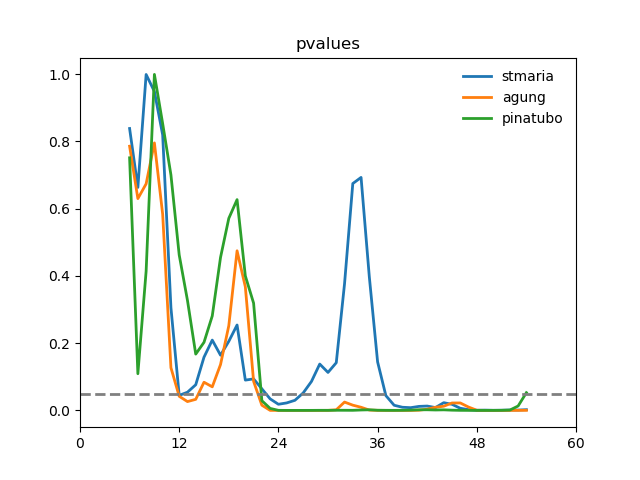

([<matplotlib.axis.XTick at 0x2b787a42a438>,
 <a list of 6 Text xticklabel objects>)

In [288]:
for volc in ['stmaria', 'agung', 'pinatubo']:
    plot(p[volc], label=volc)
plt.axhline(0.05, color='gray', ls='--')
plt.legend()
plt.title('pvalues')
plt.xticks(range(0,61,12))

In [287]:
beta['agung'].shape

(60,)

## `netrad_toa` vs `t_surf` in each year

In [291]:
# beta as the function of year
beta = dict()
p = dict()
F = dict()
volc = 'stmaria'
year = 1902
tsX = tsas_stmaria['t_surf']['Global'] 
tsY = tsas_stmaria['netrad_toa']['Global']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX
    
volc = 'agung'
year = 1963
tsX = tsas_agung['t_surf']['Global'] 
tsY = tsas_agung['netrad_toa']['Global']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX


volc = 'pinatubo'
year = 1991
tsX = tsas_pinatubo['t_surf']['Global'] 
tsY = tsas_pinatubo['netrad_toa']['Global']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX

<IPython.core.display.Javascript object>


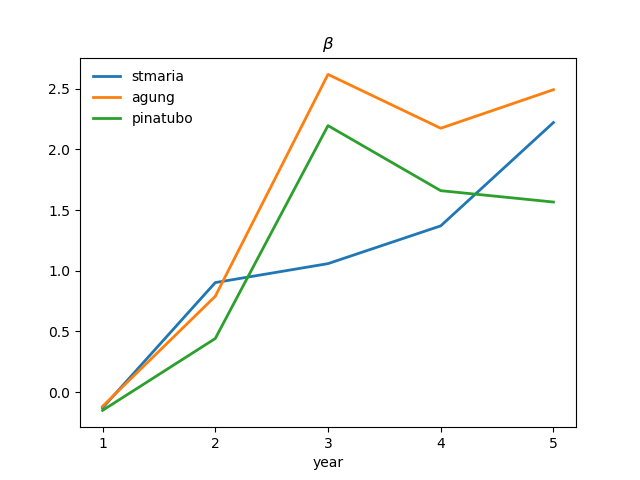

([<matplotlib.axis.XTick at 0x2b7879ea1ba8>,
 <a list of 5 Text xticklabel objects>)

In [265]:
for volc in ['stmaria', 'agung', 'pinatubo']:
    plot(range(1,6), beta[volc], label=volc)
plt.legend()
plt.title(r'$\beta$')
plt.xlabel('year')
plt.xticks(range(1,6))

<IPython.core.display.Javascript object>


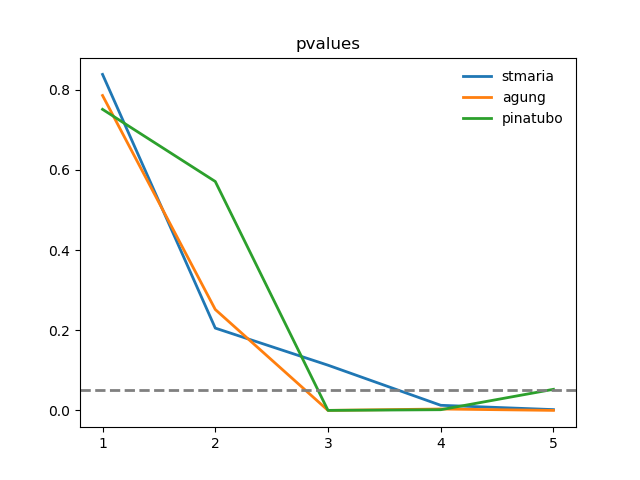

([<matplotlib.axis.XTick at 0x2b787a281080>,
 <a list of 5 Text xticklabel objects>)

In [282]:
for volc in ['stmaria', 'agung', 'pinatubo']:
    plot(range(1,6), p[volc], label=volc)
plt.axhline(0.05, color='gray', ls='--')
plt.legend()
plt.title('pvalues')
plt.xticks(range(1,6))

<IPython.core.display.Javascript object>


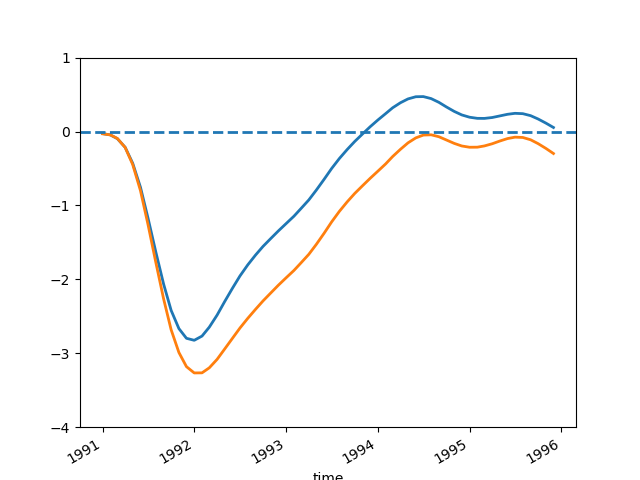

In [305]:
tsas_pinatubo['netrad_toa']['Global'].mean('en').filter.lowpass(1./12).plot()
F['pinatubo'].mean('en').filter.lowpass(1./12).plot()
plt.ylim(-4,1)
plt.axhline(0, ls='--')

<IPython.core.display.Javascript object>


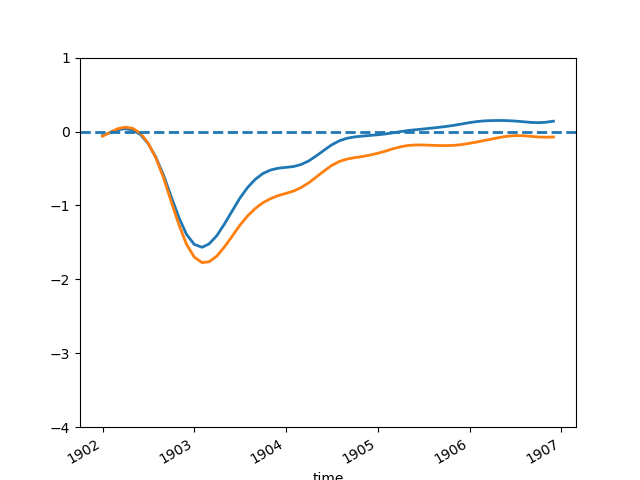

In [306]:
tsas_stmaria['netrad_toa']['Global'].mean('en').filter.lowpass(1./12).plot()
F['stmaria'].mean('en').filter.lowpass(1./12).plot()
plt.ylim(-4,1)
plt.axhline(0, ls='--')

<IPython.core.display.Javascript object>


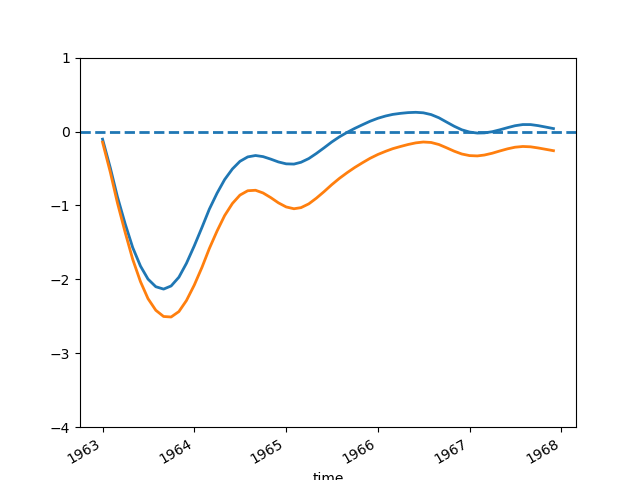

In [307]:
tsas_agung['netrad_toa']['Global'].mean('en').filter.lowpass(1./12).plot()
F['agung'].mean('en').filter.lowpass(1./12).plot()
plt.ylim(-4,1)
plt.axhline(0, ls='--')

<IPython.core.display.Javascript object>


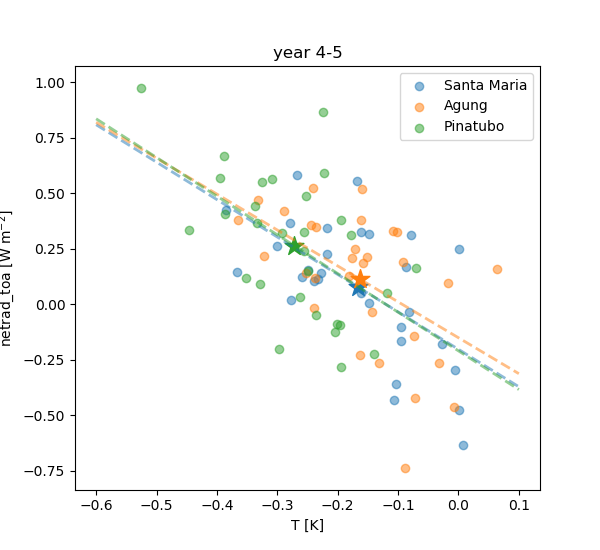

Santa Maria
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     16.74
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           0.000329
Time:                        12:21:13   Log-Likelihood:                 1.0294
No. Observations:                  30   AIC:                             1.941
Df Residuals:                      28   BIC:                             4.744
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2026      0.081     -2.

Text(0.5,1,'year 4-5')

In [255]:
# scatter plot: forcing netrad_toa of year 4-5, response of year 4-5
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -.6
Tmax = .1
iyear0 = 4
iyear = 5


volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+iyear0-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year+iyear0-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+iyear0-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year+iyear0-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+iyear0-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year+iyear0-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()


plt.legend(frameon=True)
plt.ylabel(r'netrad_toa [W m$^{-2}$]')
plt.xlabel(r'T [K]')
# plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)
plt.title(f'year {iyear0}-{iyear}')

<IPython.core.display.Javascript object>


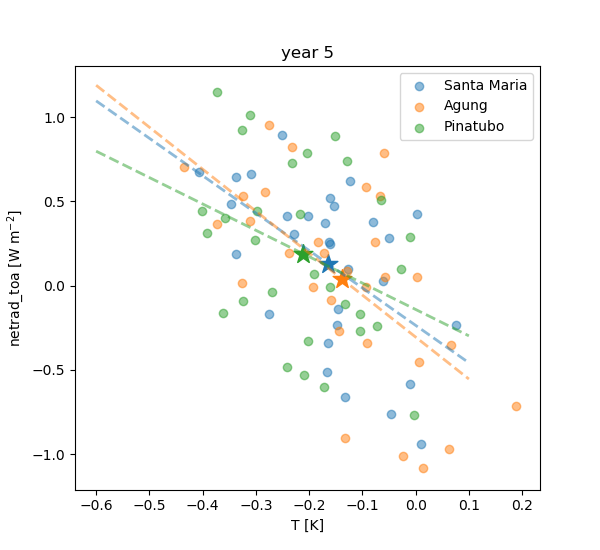

Santa Maria
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     11.46
Date:                Wed, 18 Jul 2018   Prob (F-statistic):            0.00212
Time:                        11:53:08   Log-Likelihood:                -14.864
No. Observations:                  30   AIC:                             33.73
Df Residuals:                      28   BIC:                             36.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2358      0.131     -1.

Text(0.5,1,'year 5')

In [227]:
# scatter plot: forcing netrad_toa of year 5, response of year 5
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -.6
Tmax = .1
iyear = 5


volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()


plt.legend(frameon=True)
plt.ylabel(r'netrad_toa [W m$^{-2}$]')
plt.xlabel(r'T [K]')
# plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)
plt.title(f'year {iyear}')

<IPython.core.display.Javascript object>


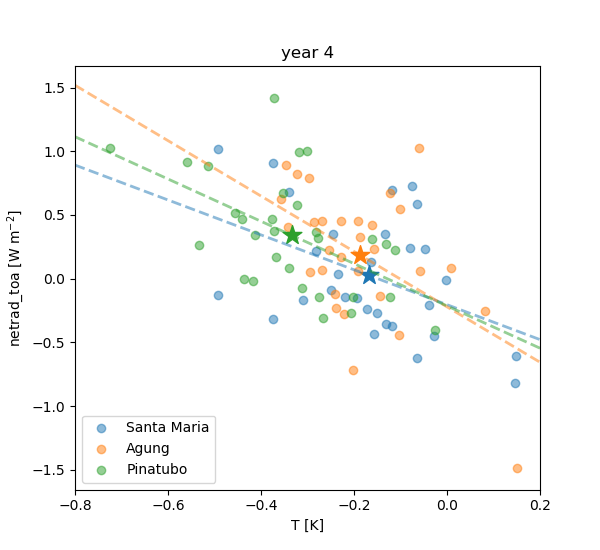

Santa Maria
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     7.055
Date:                Wed, 18 Jul 2018   Prob (F-statistic):             0.0129
Time:                        14:14:31   Log-Likelihood:                -16.306
No. Observations:                  30   AIC:                             36.61
Df Residuals:                      28   BIC:                             39.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2040      0.117     -1.

Text(0.5,1,'year 4')

In [259]:
# scatter plot: forcing netrad_toa of year 4, response of year 4
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -.8
Tmax = .2
iyear = 4


volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()


plt.legend(frameon=True, loc='lower left')
plt.ylabel(r'netrad_toa [W m$^{-2}$]')
plt.xlabel(r'T [K]')
plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)
plt.title(f'year {iyear}')

<IPython.core.display.Javascript object>


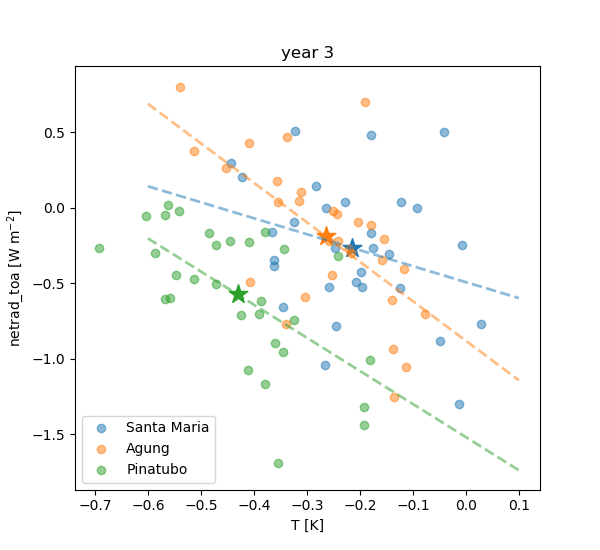

Santa Maria
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.678
Date:                Wed, 18 Jul 2018   Prob (F-statistic):              0.113
Time:                        11:42:06   Log-Likelihood:                -16.752
No. Observations:                  30   AIC:                             37.50
Df Residuals:                      28   BIC:                             40.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4929      0.160     -3.

Text(0.5,1,'year 3')

In [223]:
# scatter plot: forcing netrad_toa of year 3, response of year 3
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -.6
Tmax = .1
iyear = 3


volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()


plt.legend(frameon=True)
plt.ylabel(r'netrad_toa [W m$^{-2}$]')
plt.xlabel(r'T [K]')
# plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)
plt.title(f'year {iyear}')

<IPython.core.display.Javascript object>


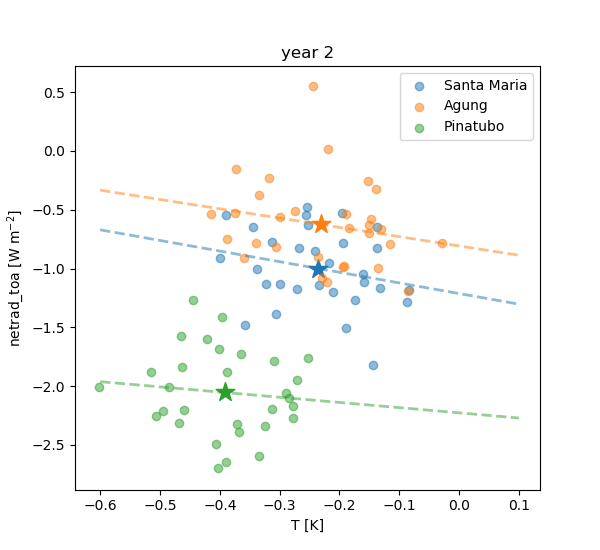

Santa Maria
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.681
Date:                Wed, 18 Jul 2018   Prob (F-statistic):              0.205
Time:                        11:42:25   Log-Likelihood:                -7.8795
No. Observations:                  30   AIC:                             19.76
Df Residuals:                      28   BIC:                             22.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2124      0.175     -6.

Text(0.5,1,'year 2')

In [224]:
# scatter plot: forcing netrad_toa of year 2, response of year 2
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -.6
Tmax = .1
iyear = 2


volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()


plt.legend(frameon=True)
plt.ylabel(r'netrad_toa [W m$^{-2}$]')
plt.xlabel(r'T [K]')
# plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)
plt.title(f'year {iyear}')

<IPython.core.display.Javascript object>


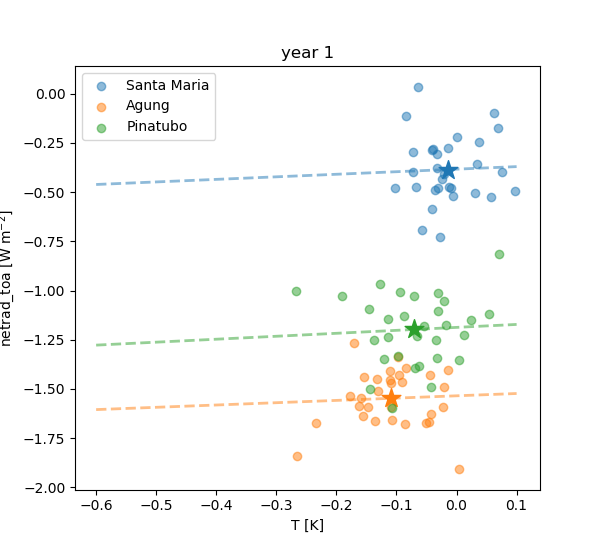

Santa Maria
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                   0.04246
Date:                Wed, 18 Jul 2018   Prob (F-statistic):              0.838
Time:                        11:51:09   Log-Likelihood:                 10.978
No. Observations:                  30   AIC:                            -17.96
Df Residuals:                      28   BIC:                            -15.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3836      0.033    -11.

Text(0.5,1,'year 1')

In [225]:
# scatter plot: forcing netrad_toa of year 1, response of year 1
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -.6
Tmax = .1
iyear = 1


volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)
X = dT.values.reshape((30,1))
X = sm.add_constant(X)
y = dR.values
result = sm.OLS(y,X).fit()
print(volname)
print(result.summary())
print()


plt.legend(frameon=True)
plt.ylabel(r'netrad_toa [W m$^{-2}$]')
plt.xlabel(r'T [K]')
# plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)
plt.title(f'year {iyear}')

### ocean only

In [58]:
# beta as the function of year
beta = dict()
p = dict()
F = dict()
volc = 'stmaria'
year = 1902
tsX = tsas_stmaria['t_surf']['ocean'] 
tsY = tsas_stmaria['netrad_toa']['ocean']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX
    
volc = 'agung'
year = 1963
tsX = tsas_agung['t_surf']['ocean'] 
tsY = tsas_agung['netrad_toa']['ocean']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX


volc = 'pinatubo'
year = 1991
tsX = tsas_pinatubo['t_surf']['ocean'] 
tsY = tsas_pinatubo['netrad_toa']['ocean']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX

<IPython.core.display.Javascript object>


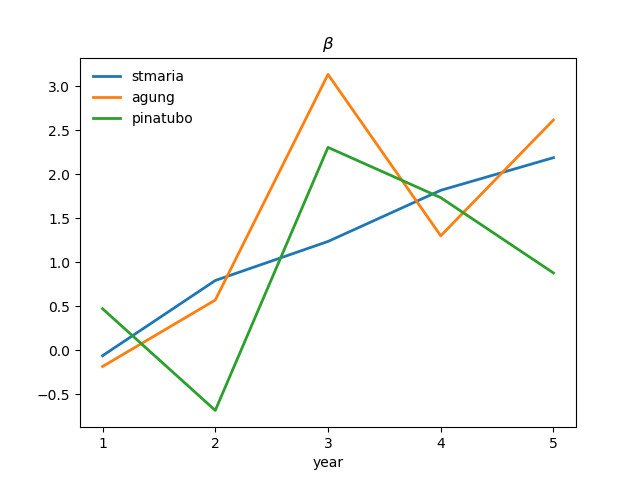

([<matplotlib.axis.XTick at 0x2b9f77bd8e80>,
 <a list of 5 Text xticklabel objects>)

In [59]:
for volc in ['stmaria', 'agung', 'pinatubo']:
    plot(range(1,6), beta[volc], label=volc)
plt.legend()
plt.title(r'$\beta$')
plt.xlabel('year')
plt.xticks(range(1,6))

<IPython.core.display.Javascript object>


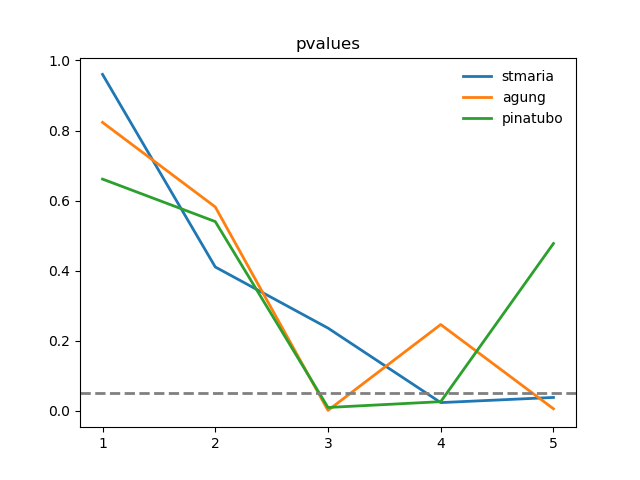

([<matplotlib.axis.XTick at 0x2b9f77c7e320>,
 <a list of 5 Text xticklabel objects>)

In [60]:
for volc in ['stmaria', 'agung', 'pinatubo']:
    plot(range(1,6), p[volc], label=volc)
plt.axhline(0.05, color='gray', ls='--')
plt.legend()
plt.title('pvalues')
plt.xticks(range(1,6))

### land only

In [61]:
# beta as the function of year
beta = dict()
p = dict()
F = dict()
volc = 'stmaria'
year = 1902
tsX = tsas_stmaria['t_surf']['land'] 
tsY = tsas_stmaria['netrad_toa']['land']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX
    
volc = 'agung'
year = 1963
tsX = tsas_agung['t_surf']['land'] 
tsY = tsas_agung['netrad_toa']['land']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX


volc = 'pinatubo'
year = 1991
tsX = tsas_pinatubo['t_surf']['land'] 
tsY = tsas_pinatubo['netrad_toa']['land']
beta[volc] = np.zeros((5,1))
p[volc] = np.zeros((5,1))
for iyear in range(1,6):
    dT = tsX.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    dR = tsY.sel(time=slice(f'{year+iyear-1}-01', f'{year+iyear-1}-12')).mean(dim='time')
    X = dT.values.reshape((30,1))
    X = sm.add_constant(X)
    y = dR.values
    result = sm.OLS(y,X).fit()
    beta[volc][iyear-1] = -result.params[1]
    p[volc][iyear-1] = result.pvalues[1]
F[volc] = tsY + beta[volc][3]*tsX

<IPython.core.display.Javascript object>


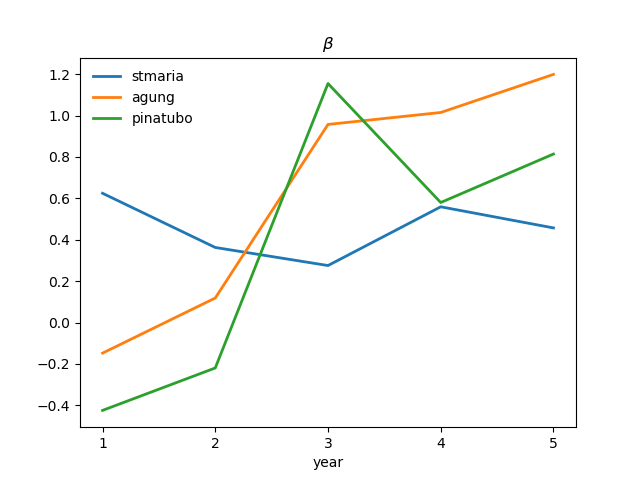

([<matplotlib.axis.XTick at 0x2b9f77a91a90>,
 <a list of 5 Text xticklabel objects>)

In [62]:
for volc in ['stmaria', 'agung', 'pinatubo']:
    plot(range(1,6), beta[volc], label=volc)
plt.legend()
plt.title(r'$\beta$')
plt.xlabel('year')
plt.xticks(range(1,6))

<IPython.core.display.Javascript object>


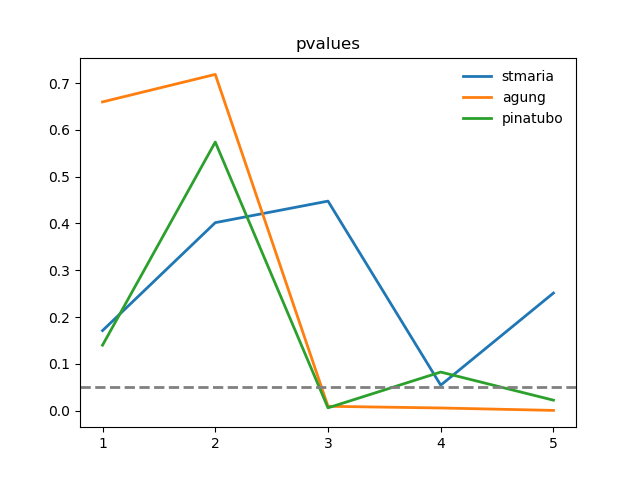

([<matplotlib.axis.XTick at 0x2b9f77d54a90>,
 <a list of 5 Text xticklabel objects>)

In [63]:
for volc in ['stmaria', 'agung', 'pinatubo']:
    plot(range(1,6), p[volc], label=volc)
plt.axhline(0.05, color='gray', ls='--')
plt.legend()
plt.title('pvalues')
plt.xticks(range(1,6))

## `netrad_toa` vs. `t_surf`

<IPython.core.display.Javascript object>


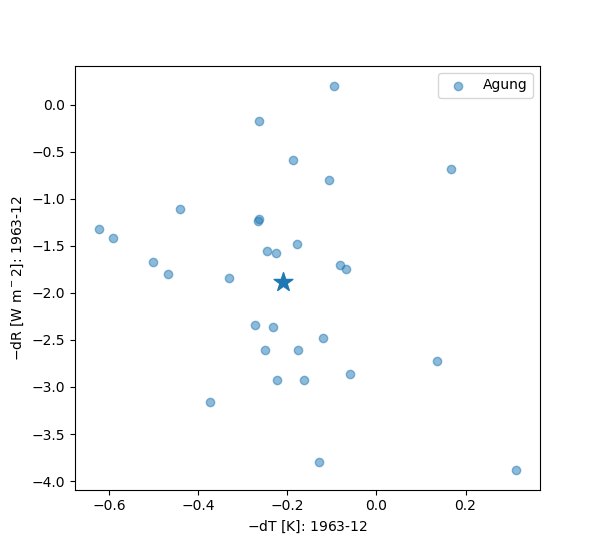

Text(0.5,0,'$-$dT [K]: 1963-12')

In [27]:
# scatter plot
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
t_agung = '1963-12'
t_stmaria = '1902-12'
t_pinatubo = '1991-12'

volname = 'Agung'
dT = tsas_agung['t_surf']['Global'].sel(time=t_agung)
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=t_agung)
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)


plt.legend(frameon=True)
plt.ylabel(f'$-$dR [W m$^{-2}$]: {t_agung}')
plt.xlabel(f'$-$dT [K]: {t_agung}')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


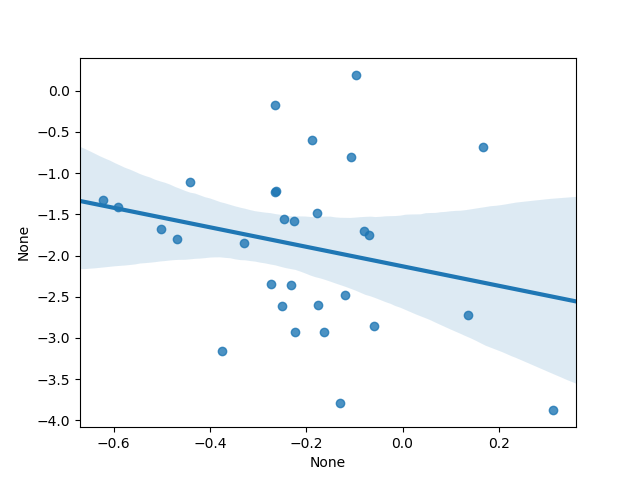

In [31]:
import seaborn as sns
sns.regplot(dT.squeeze(), dR.squeeze())

<IPython.core.display.Javascript object>


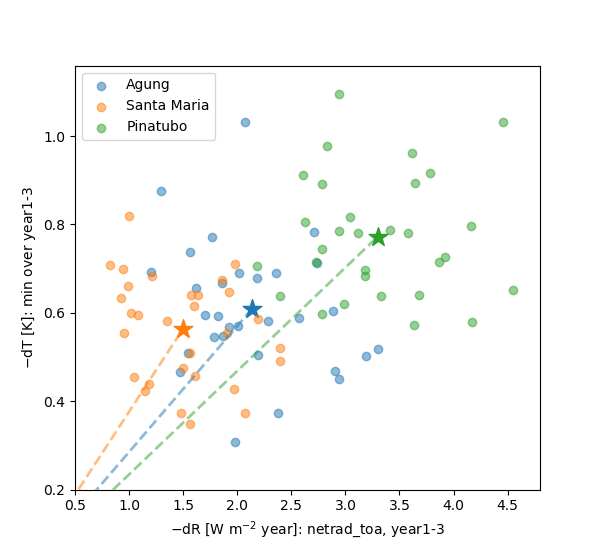

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.28496187823188585)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.37615588038611625)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.23411741253379753)


(0.2, 1.1585369214263301)

In [6]:
# scatter plot
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
dT = tsas_agung['t_surf']['Global'].min(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())

volname = 'Santa Maria'
dT = tsas_stmaria['t_surf']['Global'].min(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())

volname = 'Pinatubo'
dT = tsas_pinatubo['t_surf']['Global'].min(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netrad_toa, year1-3')
plt.ylabel('$-$dT [K]: min over year1-3')
plt.xlim(.5,None)
plt.ylim(.2, None)

<IPython.core.display.Javascript object>


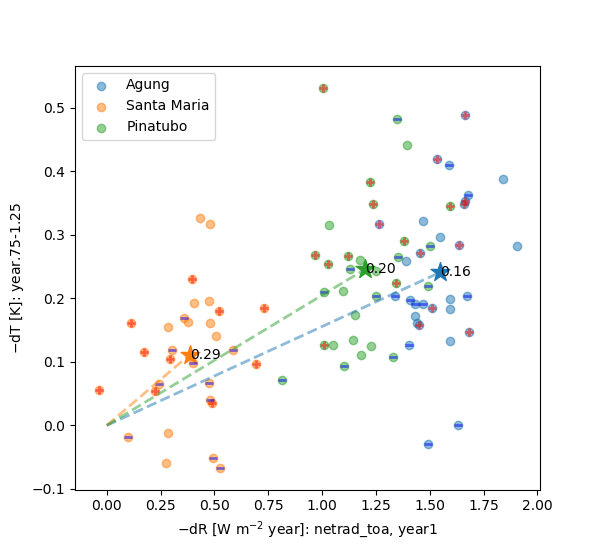

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.1555599795228192)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.2888054927681064)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.20480434755937937)


Text(0,0.5,'$-$dT [K]: year.75-1.25')

In [7]:
# scatter plot: forcing netrad_toa over year 1, response over year 0.75-1.25(Oct-Mar+)
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year}-10', f'{year+1}-03')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year}-10', f'{year+1}-03')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year}-10', f'{year+1}-03')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netrad_toa, year1')
plt.ylabel('$-$dT [K]: year.75-1.25')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


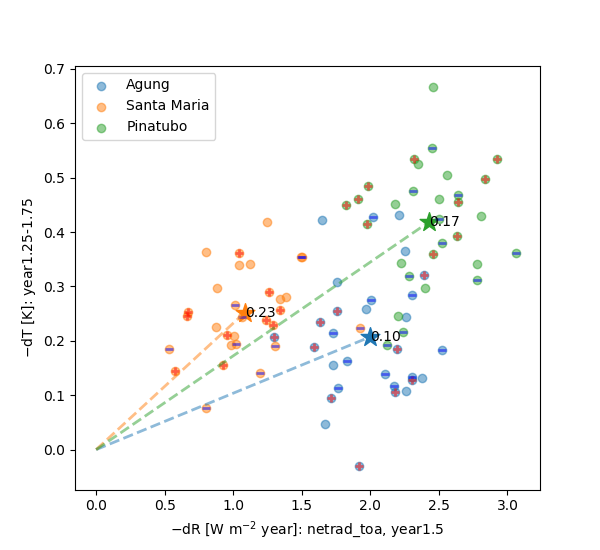

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.1036929882708378)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.2324535321480134)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.17240554079700893)


Text(0,0.5,'$-$dT [K]: year1.25-1.75')

In [8]:
# scatter plot: forcing netrad_toa over year 1.5, response over year 1.25-1.75
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+1}-04', f'{year+1}-09')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+1}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+1}-04', f'{year+1}-09')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+1}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)
    
volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+1}-04', f'{year+1}-09')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+1}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netrad_toa, year1.5')
plt.ylabel('$-$dT [K]: year1.25-1.75')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


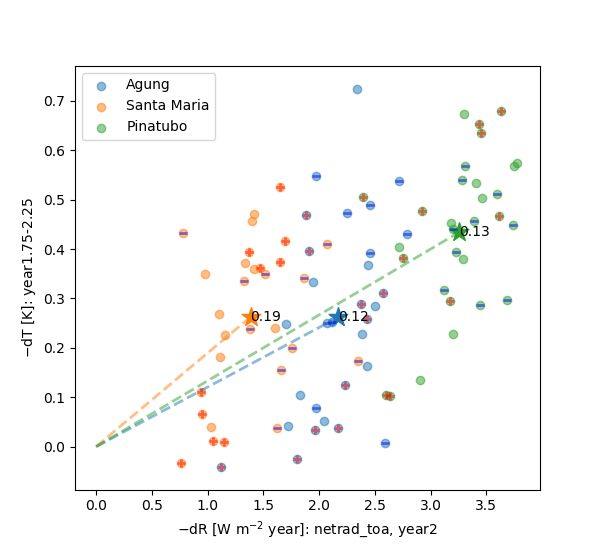

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.12058150556479384)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.18956086098103078)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.13333864260007225)


Text(0,0.5,'$-$dT [K]: year1.75-2.25')

In [9]:
# scatter plot: forcing netrad_toa over year 2, response over year 1.75-2.25(Oct-Mar+)
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+1}-10', f'{year+2}-03')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+1}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+1}-10', f'{year+2}-03')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+1}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+1}-10', f'{year+2}-03')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+1}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netrad_toa, year2')
plt.ylabel('$-$dT [K]: year1.75-2.25')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


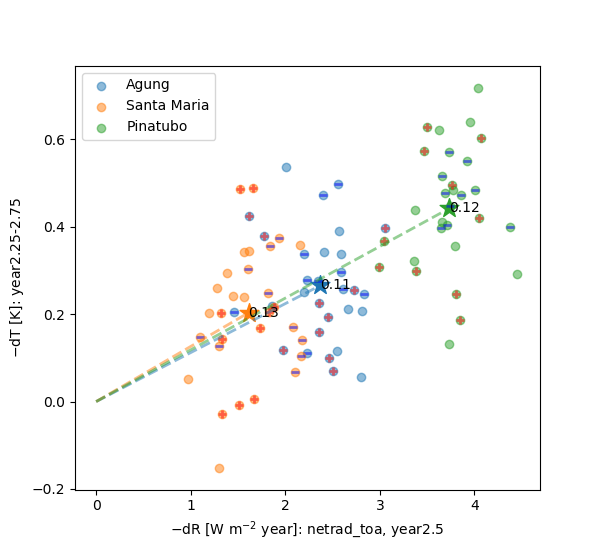

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.11203221265632131)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.12614889855087325)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.11835211308464098)


Text(0,0.5,'$-$dT [K]: year2.25-2.75')

In [10]:
# scatter plot: forcing netrad_toa over year 2.5, response over year 2.25-2.75
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+2}-04', f'{year+2}-09')).mean(dim='time')
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+2}-04', f'{year+2}-09')).mean(dim='time')
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)


volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+2}-04', f'{year+2}-09')).mean(dim='time')
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netrad_toa, year2.5')
plt.ylabel('$-$dT [K]: year2.25-2.75')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

## Volcanic radiative forcing (F) estimate

In [33]:
tss = dict()

tt = tsas_pinatubo['t_surf']['Global'].time.values
cc = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_pinatubo['t_surf']['Global'].sel(time=t).mean(dim='en')
    dRdt = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(tt[0], t)).sum(dim='time').mean('en')/12.0
    cc[i] = (dRdt/dT).item()
tss['pinatubo'] = xr.DataArray(cc, dims=('time',))

tt = tsas_agung['t_surf']['Global'].time.values
cc = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_agung['t_surf']['Global'].sel(time=t).mean(dim='en')
    dRdt = tsas_agung['netrad_toa']['Global'].sel(time=slice(tt[0], t)).sum(dim='time').mean('en')/12.0
    cc[i] = (dRdt/dT).item()
tss['agung'] = xr.DataArray(cc, dims=('time',))

tt = tsas_stmaria['t_surf']['Global'].time.values
cc = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_stmaria['t_surf']['Global'].sel(time=t).mean(dim='en')
    dRdt = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(tt[0], t)).sum(dim='time').mean('en')/12.0
    cc[i] = (dRdt/dT).item()
tss['stmaria'] = xr.DataArray(cc, dims=('time',))

<IPython.core.display.Javascript object>


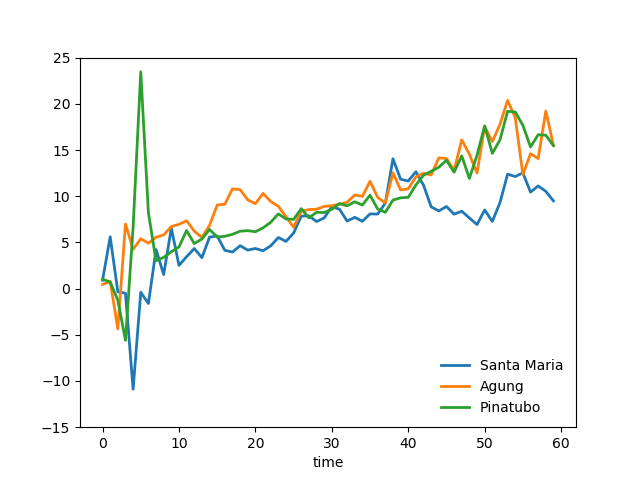

(-15, 25)

In [34]:
tss['stmaria'].plot(label='Santa Maria')
tss['agung'].plot(label='Agung')
tss['pinatubo'].plot(label='Pinatubo')

plt.legend()
ax = plt.gca()
ax.relim()
ax.autoscale_view(True, True, True)
plt.draw()
plt.ylim(-15,25)

In [30]:
tss = dict()

tt = tsas_pinatubo['t_surf']['Global'].time.values
cc = np.zeros(tt.shape)
for i,t in enumerate(tt[1:-1]):
    ts = tsas_pinatubo['t_surf']['Global']
    dT = (ts.sel(time=tt[i+1+1]) - ts.sel(time=tt[i+1-1])).mean(dim='en')
    dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=t).mean('en')
    cc[i] = (dR/dT).item()
tss['pinatubo'] = xr.DataArray(cc, dims=('time',))

tt = tsas_agung['t_surf']['Global'].time.values
cc = np.zeros(tt.shape)
for i,t in enumerate(tt[1:-1]):
    ts = tsas_agung['t_surf']['Global']
    dT = (ts.sel(time=tt[i+1+1]) - ts.sel(time=tt[i+1-1])).mean(dim='en')
    dR = tsas_agung['netrad_toa']['Global'].sel(time=t).mean('en')
    cc[i] = (dR/dT).item()
tss['agung'] = xr.DataArray(cc, dims=('time',))

tt = tsas_stmaria['t_surf']['Global'].time.values
cc = np.zeros(tt.shape)
for i,t in enumerate(tt[1:-1]):
    ts = tsas_stmaria['t_surf']['Global']
    dT = (ts.sel(time=tt[i+1+1]) - ts.sel(time=tt[i+1-1])).mean(dim='en')
    dR = tsas_stmaria['netrad_toa']['Global'].sel(time=t).mean('en')
    cc[i] = (dR/dT).item()
tss['stmaria'] = xr.DataArray(cc, dims=('time',))

<IPython.core.display.Javascript object>


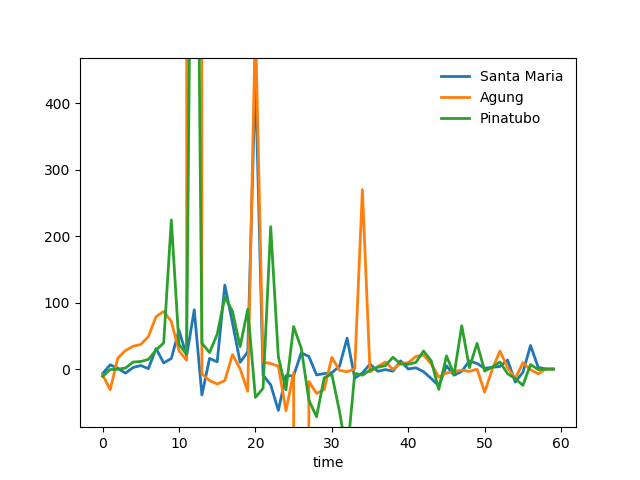

In [31]:
tss['stmaria'].plot(label='Santa Maria')
tss['agung'].plot(label='Agung')
tss['pinatubo'].plot(label='Pinatubo')

plt.legend()
ax = plt.gca()
ax.relim()
ax.autoscale_view(True, True, True)
plt.draw()
# plt.ylim(-15,25)

In [97]:
import xlearn

dT = tsas_pinatubo['t_surf']['Global'].sum('time')/12
dR = tsas_pinatubo['netrad_toa']['Global'].sum('time')/12
m = dR.learn.regress(dT)
F = m.intercept_.item()
beta = m.coef_.item()
print('Pinatubo:')
print('dR = ', -dR.mean('en').item())
print('F = ', -F)
print('beta =', -beta)
print('dT = ', -dT.mean('en').item())

dT = tsas_agung['t_surf']['Global'].sum('time')/12
dR = tsas_agung['netrad_toa']['Global'].sum('time')/12
m = dR.learn.regress(dT)
F = m.intercept_.item()
beta = m.coef_.item()
print('\nAgung:')
print('dR = ', -dR.mean('en').item())
print('F = ', -F)
print('beta =', -beta)
print('dT = ', -dT.mean('en').item())

dT = tsas_stmaria['t_surf']['Global'].sum('time')/12
dR = tsas_stmaria['netrad_toa']['Global'].sum('time')/12
m = dR.learn.regress(dT)
F = m.intercept_.item()
beta = m.coef_.item()
print('\nSanta Maria:')
print('dR = ', -dR.mean('en').item())
print('F = ', -F)
print('beta =', -beta)
print('dT = ', -dT.mean('en').item())

Pinatubo:
dR =  3.296790787741674
F =  3.932867206480313
beta = 0.44244403841133106
dT =  1.4376426474692208

Agung:
dR =  2.137900065262062
F =  2.865949138773444
beta = 0.783519285673229
dT =  0.92920376922926

Santa Maria:
dR =  1.4966979612883131
F =  1.724399371295797
beta = 0.28595805944234187
dT =  0.796275546321491


In [151]:
import xlearn
tss = dict()

tt = tsas_pinatubo['t_surf']['Global'].time.values
beta = np.zeros(tt.shape)
F = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_pinatubo['t_surf']['Global'].sel(time=t)
    dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=t)
    m = dR.learn.regress(dT)
    F[i] = m.intercept_.item()
    beta[i] = m.coef_.item()
tss['pinatubo_F'] = xr.DataArray(F, dims=('time',), coords=(tt,))
tss['pinatubo_beta'] = xr.DataArray(beta, dims=('time',), coords=(tt,))

tt = tsas_agung['t_surf']['Global'].time.values
beta = np.zeros(tt.shape)
F = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_agung['t_surf']['Global'].sel(time=t)
    dR = tsas_agung['netrad_toa']['Global'].sel(time=t)
    m = dR.learn.regress(dT)
    F[i] = m.intercept_.item()
    beta[i] = m.coef_.item()
tss['agung_F'] = xr.DataArray(F, dims=('time',), coords=(tt,))
tss['agung_beta'] = xr.DataArray(beta, dims=('time',), coords=(tt,))

tt = tsas_stmaria['t_surf']['Global'].time.values
beta = np.zeros(tt.shape)
F = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_stmaria['t_surf']['Global'].sel(time=t)
    dR = tsas_stmaria['netrad_toa']['Global'].sel(time=t)
    m = dR.learn.regress(dT)
    F[i] = m.intercept_.item()
    beta[i] = m.coef_.item()
tss['stmaria_F'] = xr.DataArray(F, dims=('time',), coords=(tt,))
tss['stmaria_beta'] = xr.DataArray(beta, dims=('time',), coords=(tt,))

<IPython.core.display.Javascript object>


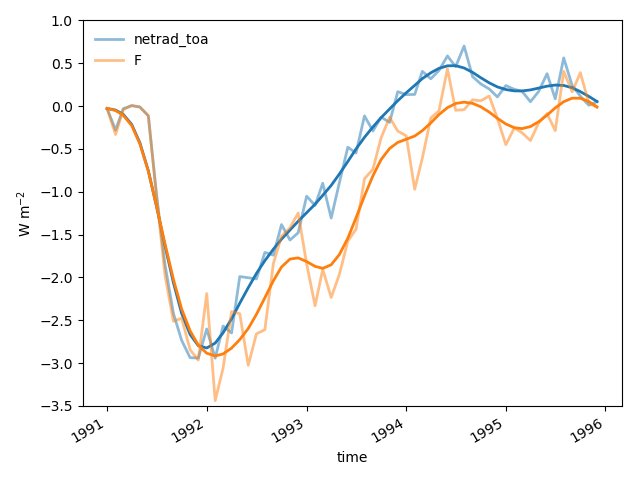

In [152]:
tsas_pinatubo['netrad_toa']['Global'].mean('en').plot(label='netrad_toa', color='C0', alpha=.5)
tsas_pinatubo['netrad_toa']['Global'].mean('en').filter.lowpass(1/12.).plot(label=None, color='C0')

tss['pinatubo_F'].plot(label='F', color='C1', alpha=.5)
tss['pinatubo_F'].filter.lowpass(1./12).plot(label=None,color='C1')

plt.legend()

plt.ylim(-3.5,1)
plt.ylabel('W m$^{-2}$')
plt.tight_layout()

<IPython.core.display.Javascript object>


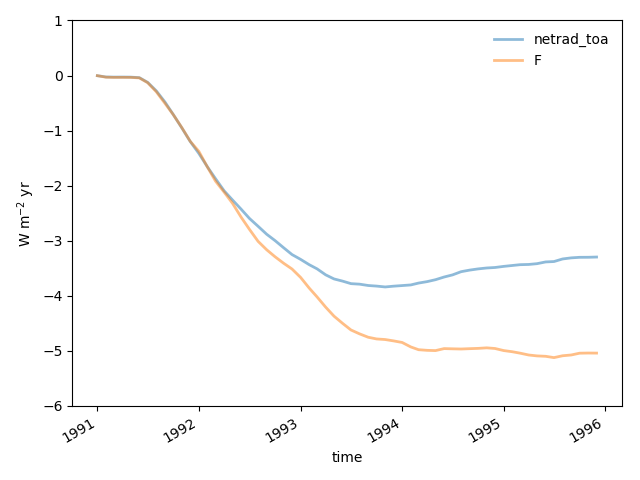

In [153]:
tsas_pinatubo['netrad_toa']['Global'].mean('en').cumsum('time').pipe(lambda x:x/12) \
    .plot(label='netrad_toa', color='C0', alpha=.5)

tss['pinatubo_F'].cumsum('time').pipe(lambda x:x/12).plot(label='F', color='C1', alpha=.5)

plt.legend()

plt.ylim(-6,1)
plt.ylabel('W m$^{-2}$ yr')
plt.tight_layout()



<IPython.core.display.Javascript object>


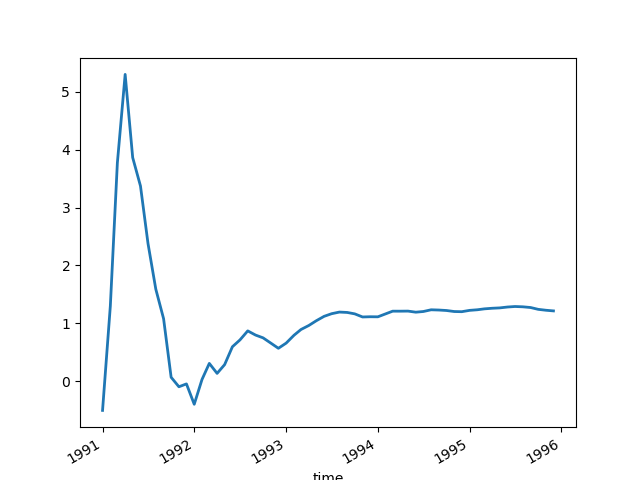

1.213865469711787


In [157]:
ts = (tss['pinatubo_F'].cumsum('time') - tsas_pinatubo['netrad_toa']['Global'].mean('en').cumsum('time')) / \
    tsas_pinatubo['t_surf']['Global'].mean('en').cumsum('time')
ts.plot()
print(ts[-1].item())

<IPython.core.display.Javascript object>


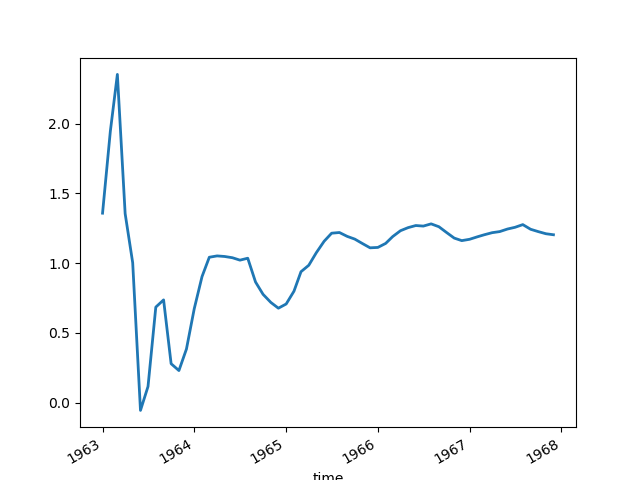

1.2029214092699874


In [158]:
ts = (tss['agung_F'].cumsum('time') - tsas_agung['netrad_toa']['Global'].mean('en').cumsum('time')) / \
    tsas_agung['t_surf']['Global'].mean('en').cumsum('time')
ts.plot()
print(ts[-1].item())

<IPython.core.display.Javascript object>


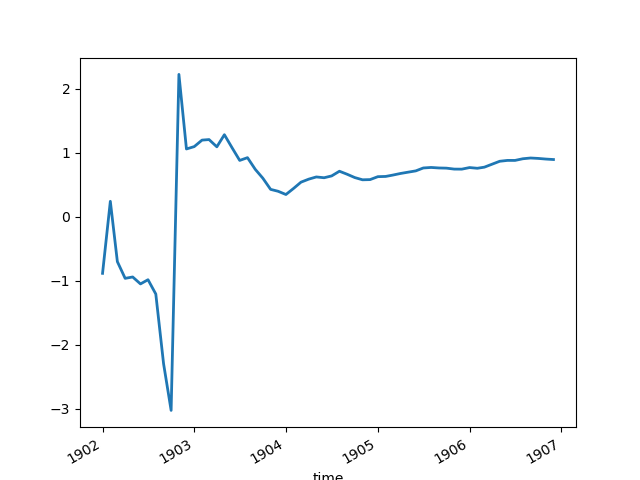

0.8911793739654035


In [159]:
ts = (tss['stmaria_F'].cumsum('time') - tsas_stmaria['netrad_toa']['Global'].mean('en').cumsum('time')) / \
    tsas_stmaria['t_surf']['Global'].mean('en').cumsum('time')
ts.plot()
print(ts[-1].item())

<IPython.core.display.Javascript object>


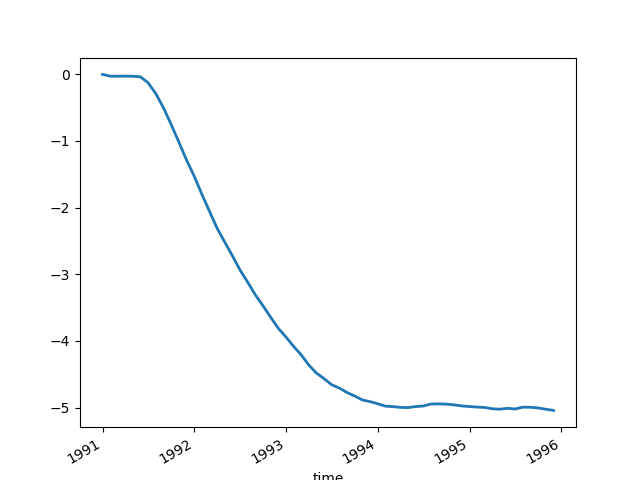

In [131]:
beta = ts[-1].item()
Ft = tsas_pinatubo['netrad_toa']['Global'].mean('en').cumsum('time')/12 + beta * tsas_pinatubo['t_surf']['Global'].mean('en').cumsum('time')/12
Ft.plot()

<IPython.core.display.Javascript object>


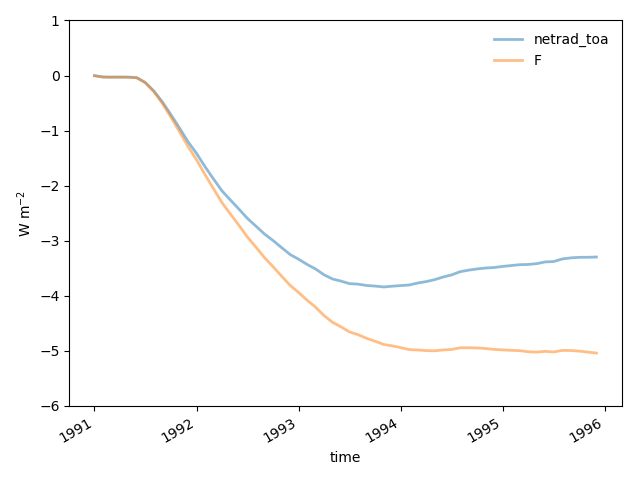

In [134]:
tsas_pinatubo['netrad_toa']['Global'].mean('en').cumsum('time').pipe(lambda x:x/12) \
    .plot(label='netrad_toa', color='C0', alpha=.5)
Ft.plot(label='F', color='C1', alpha=.5)

plt.legend()

plt.ylim(-6,1)
plt.ylabel('W m$^{-2}$')
plt.tight_layout()



<IPython.core.display.Javascript object>


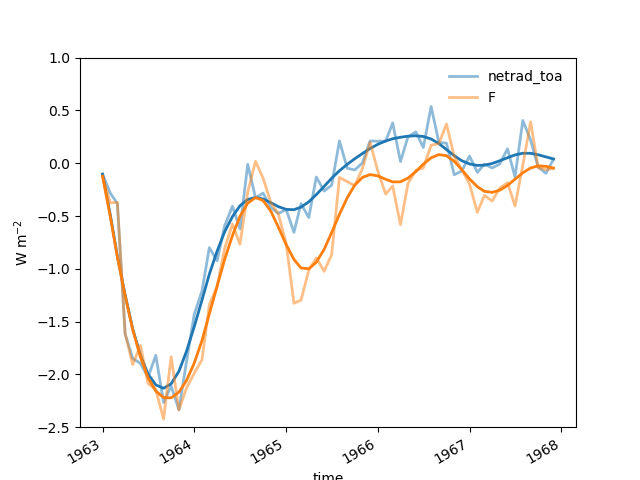

Text(0,0.5,'W m$^{-2}$')

In [74]:
tsas_agung['netrad_toa']['Global'].mean('en').plot(label='netrad_toa', color='C0', alpha=.5)
tsas_agung['netrad_toa']['Global'].mean('en').filter.lowpass(1/12.).plot(label=None, color='C0')

tss['agung_F'].plot(label='F', color='C1', alpha=.5)
tss['agung_F'].filter.lowpass(1./12).plot(label=None,color='C1')

plt.legend()

plt.ylim(-2.5,1)
plt.ylabel('W m$^{-2}$')

<IPython.core.display.Javascript object>


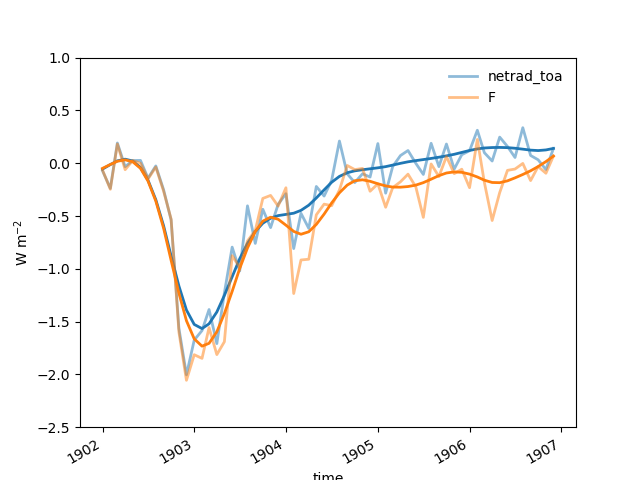

Text(0,0.5,'W m$^{-2}$')

In [75]:
tsas_stmaria['netrad_toa']['Global'].mean('en').plot(label='netrad_toa', color='C0', alpha=.5)
tsas_stmaria['netrad_toa']['Global'].mean('en').filter.lowpass(1/12.).plot(label=None, color='C0')

tss['stmaria_F'].plot(label='F', color='C1', alpha=.5)
tss['stmaria_F'].filter.lowpass(1./12).plot(label=None,color='C1')

plt.legend()

plt.ylim(-2.5,1)
plt.ylabel('W m$^{-2}$')

<IPython.core.display.Javascript object>


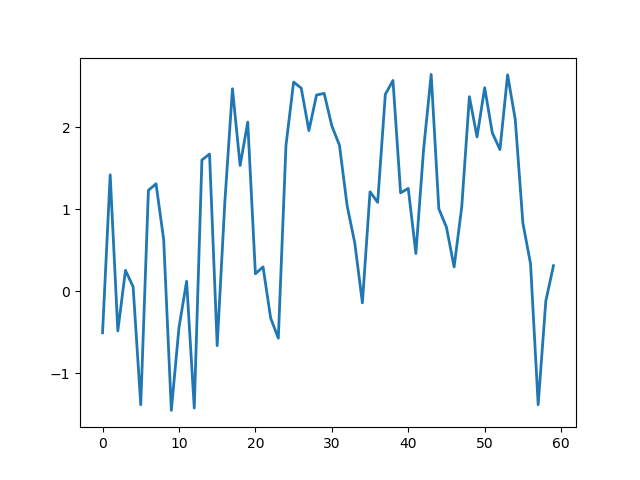

No handles with labels found to put in legend.


In [80]:
plt.plot(-tss['pinatubo_beta'])

plt.legend()

# plt.ylim(-2.5,1)
# plt.ylabel('W m$^{-2}$')

<IPython.core.display.Javascript object>


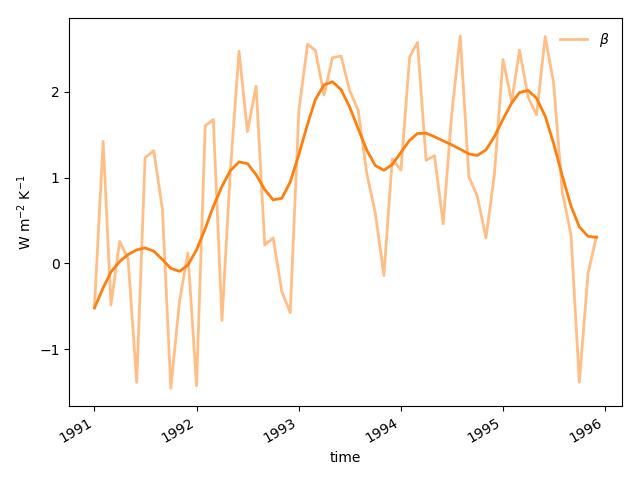

In [88]:
tss['pinatubo_beta'].pipe(lambda x: -x).plot(label=r'$\beta$', color='C0', alpha=.5)
tss['pinatubo_beta'].pipe(lambda x: -x).filter.lowpass(1./12).plot(label=None,color='C1')

plt.legend()

# plt.ylim(-3.5,1)
plt.ylabel('W m$^{-2}$ K$^{-1}$')
plt.tight_layout()

In [99]:
import xlearn
tss = dict()

tt = tsas_pinatubo['t_surf']['Global'].time.values
beta = np.zeros(tt.shape)
F = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(tt[0], t)).sum('time')/12
    dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(tt[0], t)).sum('time')/12
    m = dR.learn.regress(dT)
    F[i] = m.intercept_.item()
    beta[i] = m.coef_.item()
tss['pinatubo_F'] = xr.DataArray(F, dims=('time',), coords=(tt,))
tss['pinatubo_beta'] = xr.DataArray(beta, dims=('time',), coords=(tt,))

tt = tsas_agung['t_surf']['Global'].time.values
beta = np.zeros(tt.shape)
F = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_agung['t_surf']['Global'].sel(time=slice(tt[0], t)).sum('time')/12
    dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(tt[0], t)).sum('time')/12
    m = dR.learn.regress(dT)
    F[i] = m.intercept_.item()
    beta[i] = m.coef_.item()
tss['agung_F'] = xr.DataArray(F, dims=('time',), coords=(tt,))
tss['agung_beta'] = xr.DataArray(beta, dims=('time',), coords=(tt,))

tt = tsas_stmaria['t_surf']['Global'].time.values
beta = np.zeros(tt.shape)
F = np.zeros(tt.shape)
for i,t in enumerate(tt):
    dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(tt[0], t)).sum('time')/12
    dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(tt[0], t)).sum('time')/12
    m = dR.learn.regress(dT)
    F[i] = m.intercept_.item()
    beta[i] = m.coef_.item()
tss['stmaria_F'] = xr.DataArray(F, dims=('time',), coords=(tt,))
tss['stmaria_beta'] = xr.DataArray(beta, dims=('time',), coords=(tt,))

<IPython.core.display.Javascript object>


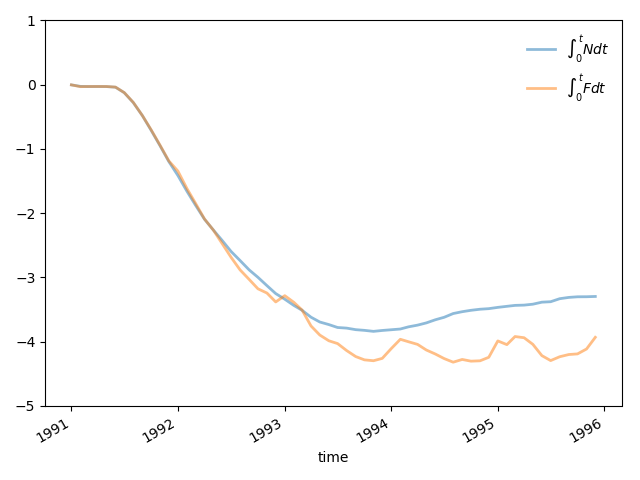

In [116]:
tsas_pinatubo['netrad_toa']['Global'].mean('en').cumsum('time').pipe(lambda x: x/12) \
    .plot(label=r'$\int_0^{t} Ndt$', color='C0', alpha=.5)

tss['pinatubo_F'].plot(label=r'$\int_0^{t} Fdt$', color='C1', alpha=.5)

plt.legend()

plt.ylim(-5,1)
# plt.ylabel('W m$^{-2}$')
plt.tight_layout()

<IPython.core.display.Javascript object>


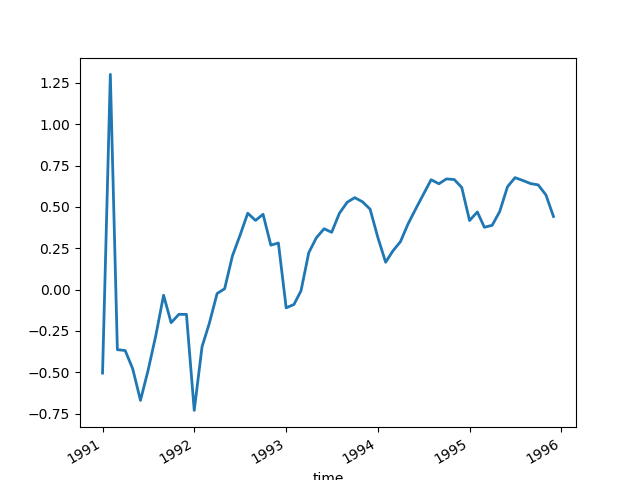

In [118]:
tss['pinatubo_beta'].pipe(lambda x:-x).plot()

## `netrad_toa` vs. `t_surf`: integrated

<IPython.core.display.Javascript object>


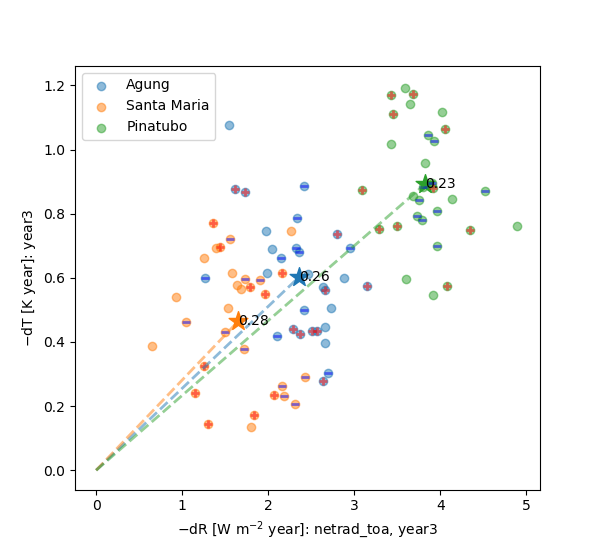

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.2554672460289942)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.28126531447102765)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.233343565526667)


Text(0,0.5,'$-$dT [K year]: year3')

In [33]:
# scatter plot: forcing netrad_toa over year 3, response over year 3
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)


volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+2}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netrad_toa, year3')
plt.ylabel('$-$dT [K year]: year3')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


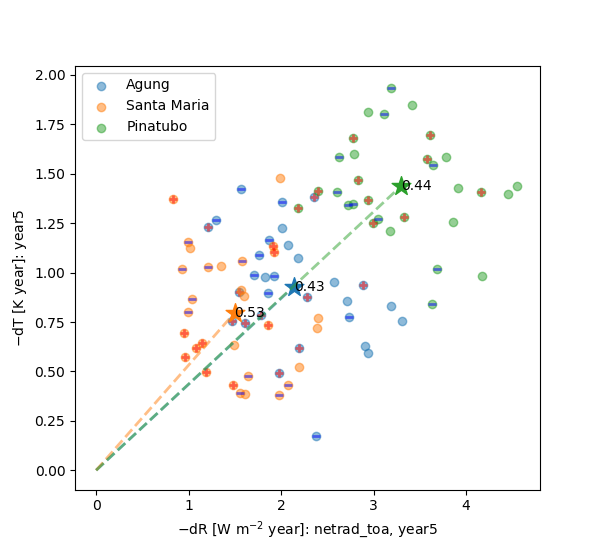

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.4346338654119265)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.5320215346829769)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.4360733634705454)


Text(0,0.5,'$-$dT [K year]: year5')

In [135]:
# scatter plot: forcing netrad_toa over year 5, response over year 5
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)


volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netrad_toa, year5')
plt.ylabel('$-$dT [K year]: year5')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


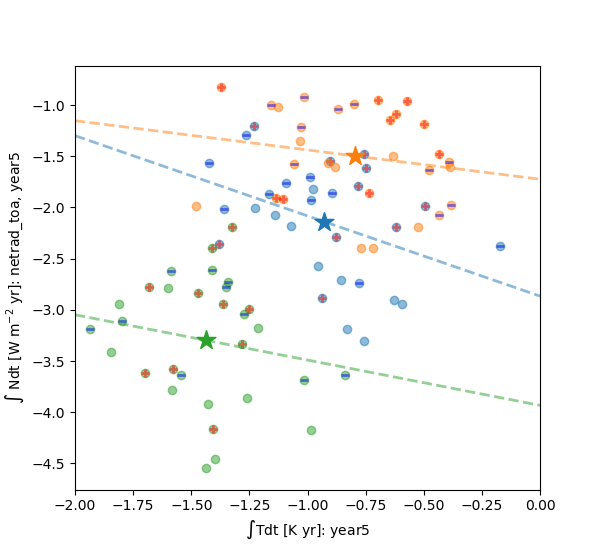

(-2, 0)

In [150]:
# scatter plot: forcing netrad_toa over year 5, response over year 5
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -2
Tmax = 0

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dT, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C0', alpha=alpha, ls='--')
for en in nino_ens:
    plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dT, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C1', alpha=alpha, ls='--')
for en in nino_ens:
    plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)



volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dT, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dT.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dT).coef_.item()
plt.plot([Tmin, Tmax], [dR.mean() - beta*(Tmin - dT.mean()), dR.mean() - beta*(Tmax - dT.mean())], 
         color='C2', alpha=alpha, ls='--')
for en in nino_ens:
    plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)

# plt.legend(frameon=True)
plt.ylabel(r'$\int$ Ndt [W m$^{-2}$ yr]: netrad_toa, year5')
plt.xlabel(r'$\int $Tdt [K yr]: year5')
plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)

## `netrad_toa` vs. `sfc_hflux_coupler`: integrated

<IPython.core.display.Javascript object>


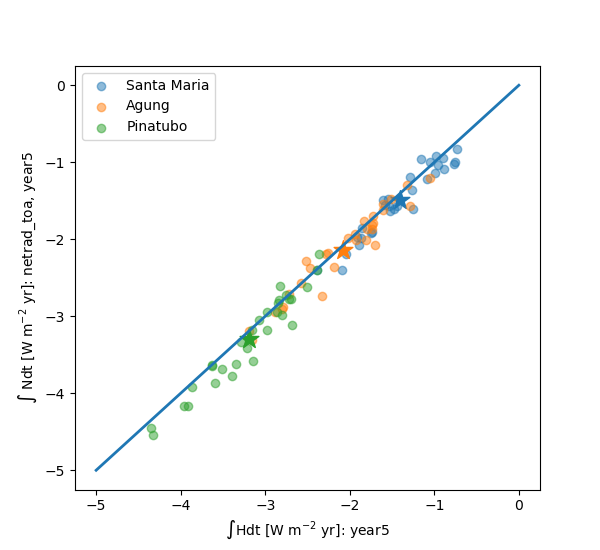

Text(0.5,0,'$\\int $Hdt [W m$^{-2}$ yr]: year5')

In [211]:
# scatter plot: forcing netrad_toa over year 5, response over year 5
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5
Tmin = -2
Tmax = 0

volname = 'Santa Maria'
year = 1902
dH = .7*tsas_stmaria['sfc_hflux_coupler']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_stmaria['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dH, dR, c='C0', label=volname, alpha=alpha)
plt.scatter(dH.mean(), dR.mean(), c='C0', marker='*', s=200)
beta = -dR.learn.regress(dH).coef_.item()
# for en in nino_ens:
#     plt.scatter(dH.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dH.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Agung'
year = 1963
dH = .7*tsas_agung['sfc_hflux_coupler']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_agung['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dH, dR, c='C1', label=volname, alpha=alpha)
plt.scatter(dH.mean(), dR.mean(), c='C1', marker='*', s=200)
beta = -dR.learn.regress(dH).coef_.item()
# for en in nino_ens:
#     plt.scatter(dH.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dH.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Pinatubo'
year = 1991
dH = .7*tsas_pinatubo['sfc_hflux_coupler']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_pinatubo['netrad_toa']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(dH, dR, c='C2', label=volname, alpha=alpha)
plt.scatter(dH.mean(), dR.mean(), c='C2', marker='*', s=200)
beta = -dR.learn.regress(dH).coef_.item()
# for en in nino_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='r', marker='+', alpha=alpha)
# for en in nina_ens:
#     plt.scatter(dT.sel(en=en), dR.sel(en=en), c='b', marker='_', alpha=alpha)

plt.plot([-5,0],[-5,0])
plt.legend(frameon=True)
plt.ylabel(r'$\int$ Ndt [W m$^{-2}$ yr]: netrad_toa, year5')
plt.xlabel(r'$\int $Hdt [W m$^{-2}$ yr]: year5')
# plt.xlim(Tmin, Tmax)
# # plt.ylim(.2, None)

## netsw_toa vs `t_surf`

<IPython.core.display.Javascript object>


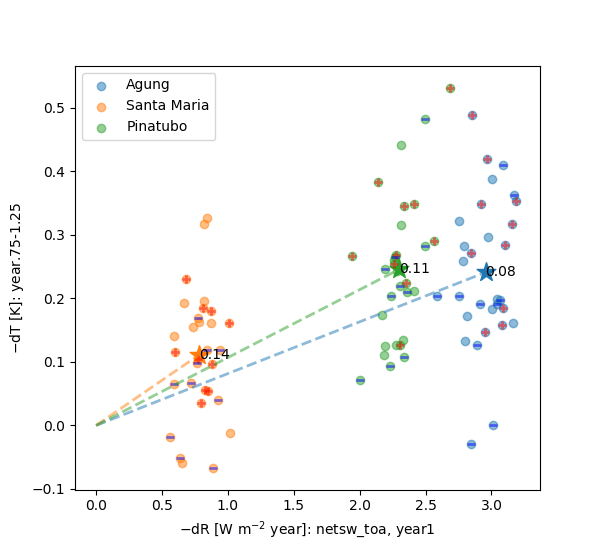

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.0814850614186581)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.1420015667654516)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.10677255016422554)


Text(0,0.5,'$-$dT [K]: year.75-1.25')

In [11]:
# scatter plot: forcing netsw_toa over year 1, response over year 0.75-1.25(Oct-Mar+)
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year}-10', f'{year+1}-03')).mean(dim='time')
# print(dT)
dR = (tsas_agung['swdn_toa_clr']['Global'] - tsas_agung['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year}-10', f'{year+1}-03')).mean(dim='time')
# print(dT)
dR = (tsas_stmaria['swdn_toa_clr']['Global'] - tsas_stmaria['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year}-10', f'{year+1}-03')).mean(dim='time')
# print(dT)
dR = (tsas_pinatubo['swdn_toa_clr']['Global'] -  tsas_pinatubo['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netsw_toa, year1')
plt.ylabel('$-$dT [K]: year.75-1.25')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


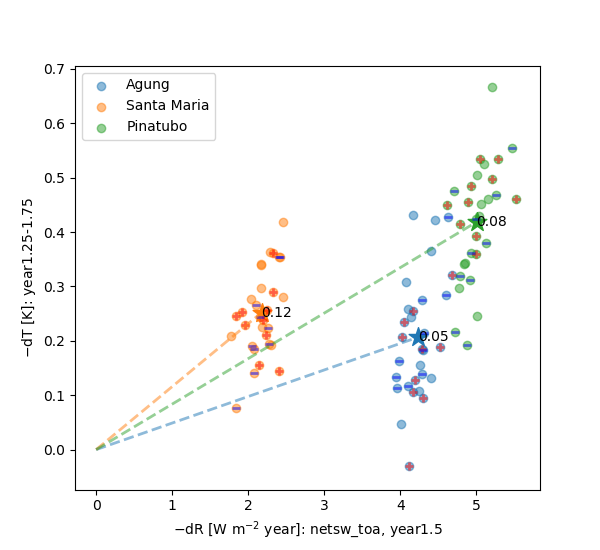

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.048811810696263745)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.11578715107131032)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.08365164404932633)


Text(0,0.5,'$-$dT [K]: year1.25-1.75')

In [12]:
# scatter plot: forcing netsw_toa over year 1.5, response over year 1.25-1.75
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+1}-04', f'{year+1}-09')).mean(dim='time')
# print(dT)
dR = (tsas_agung['swdn_toa_clr']['Global'] - tsas_agung['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+1}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+1}-04', f'{year+1}-09')).mean(dim='time')
# print(dT)
dR = (tsas_stmaria['swdn_toa_clr']['Global'] - tsas_stmaria['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+1}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+1}-04', f'{year+1}-09')).mean(dim='time')
# print(dT)
dR = (tsas_pinatubo['swdn_toa_clr']['Global'] -  tsas_pinatubo['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+1}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netsw_toa, year1.5')
plt.ylabel('$-$dT [K]: year1.25-1.75')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


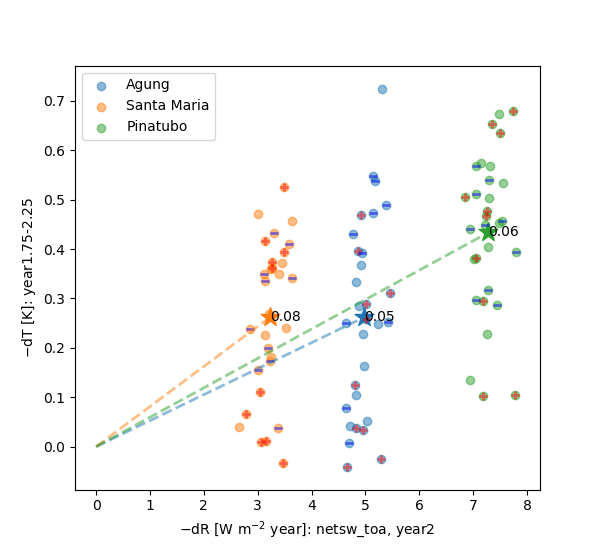

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.05262975022340385)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.08118473401471256)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.059532696760780775)


Text(0,0.5,'$-$dT [K]: year1.75-2.25')

In [13]:
# scatter plot: forcing netsw_toa over year 2, response over year 1.75-2.25(Oct-Mar+)
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+1}-10', f'{year+2}-03')).mean(dim='time')
# print(dT)
dR = (tsas_agung['swdn_toa_clr']['Global'] - tsas_agung['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+1}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+1}-10', f'{year+2}-03')).mean(dim='time')
# print(dT)
dR = (tsas_stmaria['swdn_toa_clr']['Global'] - tsas_stmaria['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+1}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+1}-10', f'{year+2}-03')).mean(dim='time')
# print(dT)
dR = (tsas_pinatubo['swdn_toa_clr']['Global'] -  tsas_pinatubo['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+1}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netsw_toa, year2')
plt.ylabel('$-$dT [K]: year1.75-2.25')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

<IPython.core.display.Javascript object>


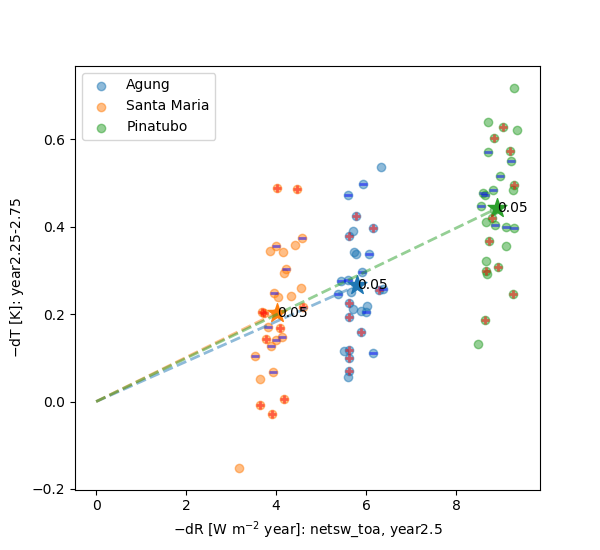

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.04575061531644507)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.05060961799131362)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.049614635444839024)


Text(0,0.5,'$-$dT [K]: year2.25-2.75')

In [14]:
# scatter plot: forcing netsw_toa over year 2.5, response over year 2.25-2.75
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year+2}-04', f'{year+2}-09')).mean(dim='time')
# print(dT)
dR = (tsas_agung['swdn_toa_clr']['Global'] - tsas_agung['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+2}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year+2}-04', f'{year+2}-09')).mean(dim='time')
# print(dT)
dR = (tsas_stmaria['swdn_toa_clr']['Global'] - tsas_stmaria['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+2}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year+2}-04', f'{year+2}-09')).mean(dim='time')
# print(dT)
dR = (tsas_pinatubo['swdn_toa_clr']['Global'] -  tsas_pinatubo['swup_toa_clr']['Global']) \
    .sel(time=slice(f'{year}-01', f'{year+2}-06')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netsw_toa, year2.5')
plt.ylabel('$-$dT [K]: year2.25-2.75')
# plt.xlim(.5,None)
# plt.ylim(.2, None)

# plt.savefig('~/tigress/public_html/pub/volcano/fig.pdf')

<IPython.core.display.Javascript object>


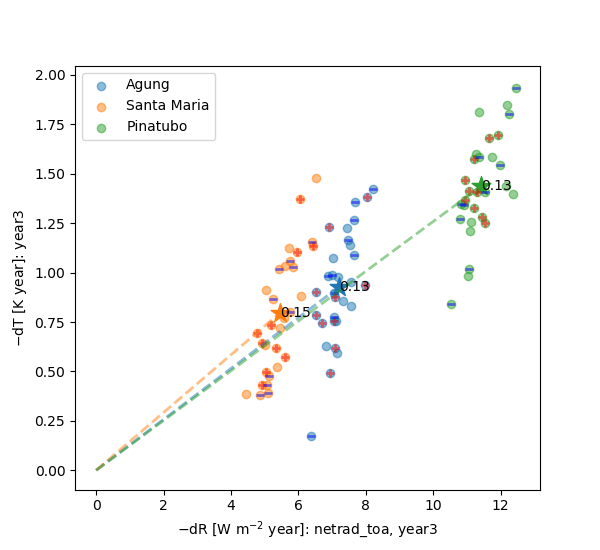

[dT]/[dR] of Agung: <xarray.DataArray ()>
array(0.12871137713661807)
[dT]/[dR] of Santa Maria: <xarray.DataArray ()>
array(0.14603251987764307)
[dT]/[dR] of Pinatubo: <xarray.DataArray ()>
array(0.12586001317542594)


Text(0,0.5,'$-$dT [K year]: year3')

In [39]:
# scatter plot: forcing swdn_toa_clr over year 5, response over year 5
fig, axes = plt.subplots(1,1, figsize=(6,5.5))
alpha = .5

volname = 'Agung'
year = 1963
dT = tsas_agung['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_agung['swup_toa_clr']['Global'].pipe(lambda x: x*(-1)) \
    .sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C0', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C0', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C0', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Agung:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

volname = 'Santa Maria'
year = 1902
dT = tsas_stmaria['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_stmaria['swup_toa_clr']['Global'].pipe(lambda x: x*(-1)) \
    .sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C1', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C1', marker='*', s=200)
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C1', alpha=alpha, ls='--')
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
print('[dT]/[dR] of Santa Maria:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)


volname = 'Pinatubo'
year = 1991
dT = tsas_pinatubo['t_surf']['Global'].sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dT)
dR = tsas_pinatubo['swup_toa_clr']['Global'].pipe(lambda x: x*(-1)) \
    .sel(time=slice(f'{year}-01', f'{year+4}-12')).sum(dim='time')/12.0
# print(dR)

plt.scatter(-dR, -dT, c='C2', label=volname, alpha=alpha)
plt.scatter(-dR.mean(), -dT.mean(), c='C2', marker='*', s=200)
plt.text(-dR.mean(), -dT.mean(), f'{(dT.mean()/dR.mean()).item():.2f}', ha='left', va='center')
plt.plot([0, -dR.mean()], [0, -dT.mean()], color='C2', alpha=alpha, ls='--')
print('[dT]/[dR] of Pinatubo:', dT.mean()/dR.mean())
for en in nino_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='r', marker='+', alpha=alpha)
for en in nina_ens:
    plt.scatter(-dR.sel(en=en), -dT.sel(en=en), c='b', marker='_', alpha=alpha)

plt.legend(frameon=True)
plt.xlabel('$-$dR [W m$^{-2}$ year]: netrad_toa, year3')
plt.ylabel('$-$dT [K year]: year3')
# plt.xlim(.5,None)
# plt.ylim(.2, None)